In [1]:
import sys
sys.path.append("..")

In [2]:
# import gymnasium as gym
# from gymnasium.envs.toy_text.frozen_lake import generate_random_map
# from matplotlib import pyplot as plt

# grid_size = 12
# grid_shape = (grid_size, grid_size)
# env_description = generate_random_map(size=grid_size//2, p=0.8)
# #env_description = list(map(lambda row: row.replace("F", "S"), env_description))
# # mirror map both vertically and horizontally
# env_description = [row[::-1]+ row for row in env_description[::-1] + env_description]

# env = gym.make(
#     "FrozenLake-v1",
#     desc=env_description,
#     is_slippery=False,
#     render_mode="rgb_array",
# )

# print(env.reset())
# plt.imshow(env.render())
# plt.show()

In [3]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from matplotlib import pyplot as plt
from mango.environments import CustomFrozenLakeEnv


grid_size = 12
env_description = generate_random_map(size=grid_size//2, p=0.8)
env_description = list(map(lambda row: row.replace("F", "S"), env_description))
# mirror map both vertically and horizontally
env_description = [row[::-1]+ row for row in env_description[::-1] + env_description]

env = CustomFrozenLakeEnv(
    "FrozenLake-v1",
    desc=env_description,
    is_slippery=False,
    render_mode="rgb_array",
    state_mode = "flattened_one_hot",
    env_mode="training_priors"
)

x= env.reset()
grid_shape = (12,12,4)

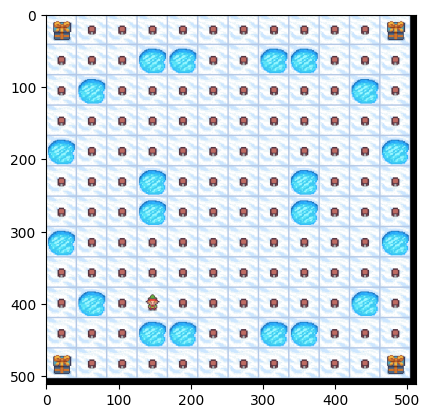

In [4]:
env.reset()
plt.imshow(env.render())

In [5]:
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# for i in range(4):
#     axs[i].imshow(x[0][:, :, i], cmap='gray', interpolation='nearest')
#     axs[i].set_title(f'Channel {i+1}')

In [6]:
# from mango.concepts import OneHotCondensation
# import numpy as np


# concept = OneHotCondensation(x[0].shape,condensation_window=(2,2))
# concept2 = OneHotCondensation(x[0].shape,condensation_window=(4,4))
# y = concept2.abstract(x[0])
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# for i in range(4):
#     axs[i].imshow(y[:, :, i], cmap='gray', interpolation='nearest')
#     axs[i].set_title(f'Channel {i+1}')

In [7]:
# from mango.masking_window import CounterCondensationWindow
# mask = CounterCondensationWindow(x[0].shape,condensation_window=(4,4))
# obs_mask = mask._decondensing_concept(y)
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# print(y.transpose(2,0,1))

# for i in range(4):
#     axs[i].imshow(obs_mask[:, :, i], cmap='gray', interpolation='nearest')
#     axs[i].set_title(f'Channel {i+1}')

In [8]:
from mango.concepts import Int2CoordConcept
from mango.actions import CondensationCompatibility
from mango.masking_window import CounterCondensationWindow
from mango.concepts import OneHotCondensation

base_concept = OneHotCondensation(grid_shape, name = "0", condensation_window=(1, 1))
concepts = [
    OneHotCondensation(grid_shape, name = "1", condensation_window=(2, 2)),
    OneHotCondensation(grid_shape, name = "2", condensation_window=(4, 4)),
]
action_compatabilities = [
    CondensationCompatibility(),
    CondensationCompatibility(),
]
masks = [CounterCondensationWindow(grid_shape,condensation_window=(2,2)),
         CounterCondensationWindow(grid_shape,condensation_window=(4,4)),
         ]

In [9]:
from mango.mango import Mango

mango = Mango(
    environment=env,
    concepts=concepts,
    action_compatibilities=action_compatabilities,
    masks=masks,
    base_concept=base_concept,
    verbose = 0
)
print(mango)
print(f"{mango.option_space=}")

Mango(
  (0): MangoEnv(
    (concept): OneHotCondensation(global_shape=(12, 12, 4), name='0', condensation_window=(1, 1))
    (environment): <CustomFrozenLakeEnv<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>>
  )
  (1): MangoEnv(
    (concept): OneHotCondensation(global_shape=(12, 12, 4), name='0', condensation_window=(1, 1))
    (environment): <CustomFrozenLakeEnv<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>>
  )
  (2): MangoLayer(
    (concept): OneHotCondensation(global_shape=(12, 12, 4), name='1', condensation_window=(2, 2))
    (act_comp): CondensationCompatibility()
    (policy): DQnetPolicyMapper(
      (0): DQnetPolicy(action_space=Discrete(4))
      (1): DQnetPolicy(action_space=Discrete(4))
      (2): DQnetPolicy(action_space=Discrete(4))
      (3): DQnetPolicy(action_space=Discrete(4))
    )
  )
  (3): MangoLayer(
    (concept): OneHotCondensation(global_shape=(12, 12, 4), name='2', condensation_window=(4, 4))
    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
mango.change_verbose(0)

In [13]:
import tqdm.notebook as tqdm
from mango.utils import smooth

for _ in tqdm.trange(10):
    for layer in [1,2]:
        N = int(100)
        for i in tqdm.trange(N):
            epsilon = pow(100,((N-i)/N-1))-1/100
            mango.explore(layer_idx=layer, max_steps=5, randomness=epsilon)
            mango.train(layer_idx=layer)
            
    plt.figure(figsize=(12, 4))
    for i, layer in enumerate(mango.abstract_layers):
        plt.subplot(1, len(mango.abstract_layers), i + 1)
        plt.title(f"loss Layer {i+1}")
        for comand, policy in layer.policy.policies.items():
            plt.plot(smooth(policy.loss_log), label=comand)
        plt.legend()    
        
    plt.figure(figsize=(12, 4))
    for i, layer in enumerate(mango.abstract_layers):
        plt.subplot(1, len(mango.abstract_layers), i + 1)
        plt.title(f"reward Layer {i+1}")
        for comand, log in enumerate(layer.debug_log):
            plt.plot(smooth(log, int(100/(1+i))), label=comand)
        plt.legend() 
           

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'smooth' is not defined

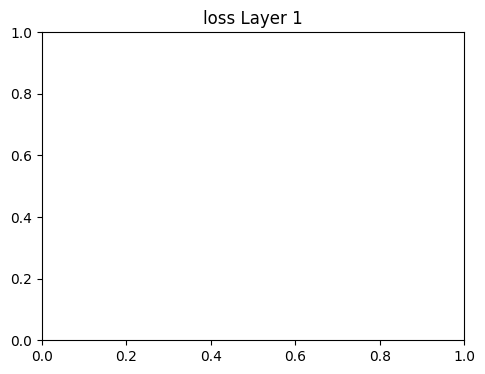

In [12]:


# plt.figure(figsize=(12, 4))
# for i, layer in enumerate(mango.abstract_layers):
#     plt.subplot(1, len(mango.abstract_layers), i + 1)
#     plt.title(f"loss Layer {i+1}")
#     for comand, policy in layer.policy.policies.items():
#         plt.plot(smooth(policy.loss_log), label=comand)
#     plt.legend()    
    
# plt.figure(figsize=(12, 4))
# for i, layer in enumerate(mango.abstract_layers):
#     plt.subplot(1, len(mango.abstract_layers), i + 1)
#     plt.title(f"reward Layer {i+1}")
#     for comand, log in enumerate(layer.debug_log):
#         plt.plot(smooth(log, int(100/(1+i))), label=comand)
#     plt.legend()   

Layer 2 action left
-Layer 1 action up
-Layer 1 reward -0.01
Layer 2 reward -0.01


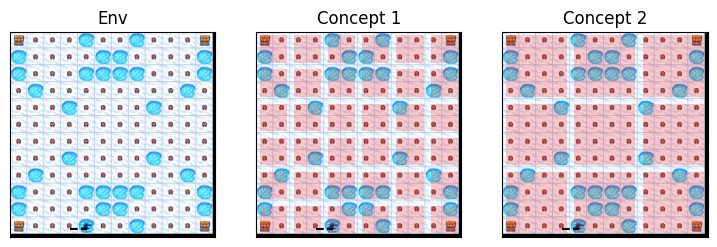

Layer 2 action down
-Layer 1 action down
-Layer 1 reward -0.01
-Layer 1 action left
-Layer 1 reward -0.02
Layer 2 reward -0.03


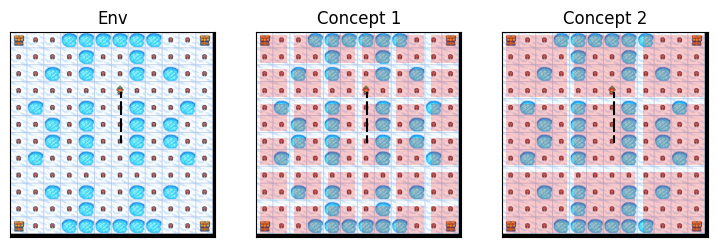

Layer 2 action right
-Layer 1 action left
-Layer 1 reward -0.01
Layer 2 reward -0.01


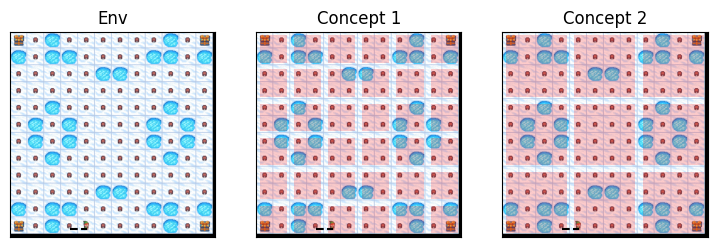

Layer 2 action up
-Layer 1 action right
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
-Layer 1 action up
-Layer 1 reward -0.01
Layer 2 reward -0.09999999999999999


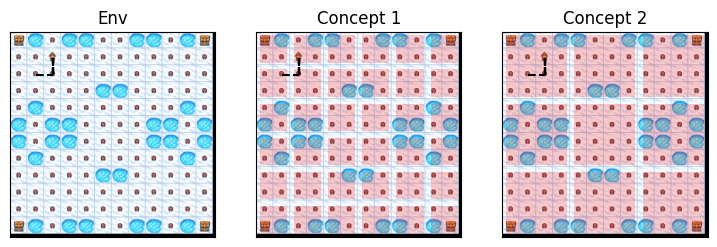

In [23]:
from mango.utils import plot_grid, plot_trajectory
import numpy as np
for action in [0,1,2,3]:
    start_state, info = mango.reset()
    mango.change_verbose(2)
    end_state, reward, trunc, term, info = mango.execute_option(action=action, layer_idx=2, randomness = 0.1)
    img = env.render()

    plt.figure(figsize=((1 + len(concepts)) * 3, 3))
    for i, concept in enumerate([None] + concepts):
        plt.subplot(1, len(concepts) + 1, 1 + i)
        plt.title("Env" if concept is None else f"Concept {i}")
        plt.imshow(img)  # type: ignore
        if concept is not None:
            plot_grid(grid_shape, concept.condensation_window) # type: ignore
        trajectory = [np.argmax(x.reshape(grid_shape)[:,:,-1]) for x in info["mango:trajectory"]]
        start_state_ch = np.argmax(start_state.reshape(grid_shape)[:,:,-1])
        plot_trajectory(start_state_ch, trajectory, grid_shape[:2])
        plt.xticks([])
        plt.yticks([])
    plt.show()

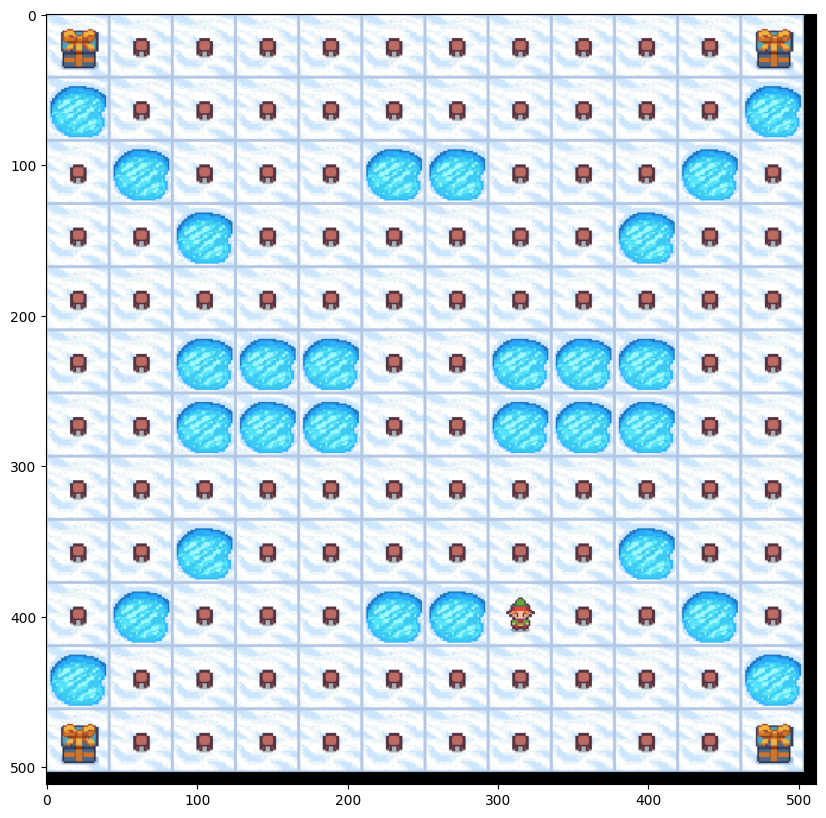

In [ ]:
env.reset()
env.render()

(0.0, False, False, {'prob': 1.0})


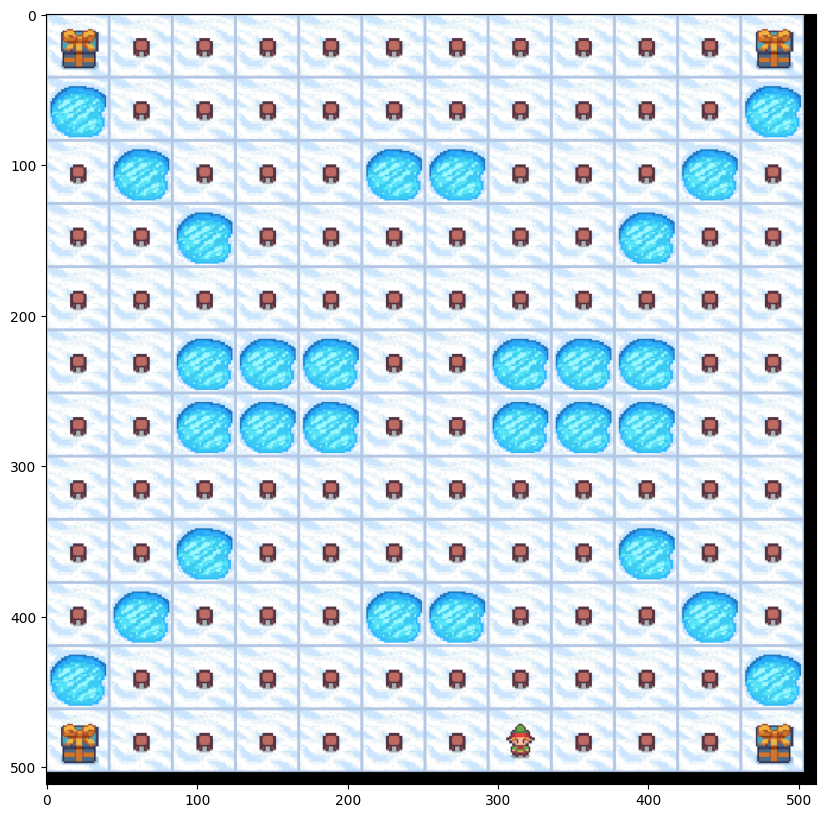

In [ ]:
print(env.step(1)[1:])
env.render()